# Visualizing weights with captum.optim

This notebook demonstrates the use of the captum.optim submodule for visualizing the weights of the InceptionV1 model imported from Caffe.

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
from captum.optim._models.inception_v1 import googlenet

import captum.optim as optimviz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device).eval()

For convenience, we can create helper functions for visualizing the weights of our model.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def show(x: np.ndarray, scale: float = 255.0) -> None:
    assert len(x.shape) == 3
    x = x.permute(1,2,0).numpy() if torch.is_tensor(x) else x
    if x.shape[2] == 1:
        x = np.concatenate([x, x, x], 2)
    x = x * scale
    plt.imshow(x.astype(np.uint8))
    plt.axis("off")
    plt.show()


def tensor_heatmap(
    tensor: torch.Tensor,
    colors=["0571b0", "92c5de", "f7f7f7", "f4a582", "ca0020"],
) -> torch.Tensor:
    """
    Create a color heatmap of an input tensor.
    """

    assert len(colors) == 5

    def get_color(x: str) -> torch.Tensor:
        def hex2base10(x: str) -> float:
            return int(x, 16) / 255.0

        return torch.tensor(
            [hex2base10(x[0:2]), hex2base10(x[2:4]), hex2base10(x[4:6])]
        )

    def color_scale(x: torch.Tensor) -> torch.Tensor:
        if x < 0:
            x = -x
            if x < 0.5:
                x = x * 2
                return (1 - x) * get_color(colors[2]) + x * get_color(colors[1])
            else:
                x = (x - 0.5) * 2
                return (1 - x) * get_color(colors[1]) + x * get_color(colors[0])
        else:
            if x < 0.5:
                x = x * 2
                return (1 - x) * get_color(colors[2]) + x * get_color(colors[3])
            else:
                x = (x - 0.5) * 2
                return (1 - x) * get_color(colors[3]) + x * get_color(colors[4])

    return torch.stack([torch.stack([color_scale(x) for x in t]) for t in tensor]).permute(2, 0, 1)


def visualize_activations(model, target, channel: int, neuron=True) -> None:
    image = optimviz.images.NaturalImage((224, 224)).to(device)
    transforms = torch.nn.Sequential(
        torch.nn.ReflectionPad2d(16),
        optimviz.transform.RandomSpatialJitter(16),
        optimviz.transform.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5,5)),
        optimviz.transform.RandomSpatialJitter(8),
        optimviz.transform.CenterCrop(16),
    )
    if neuron:
        loss_fn = optimviz.loss.NeuronActivation(target, channel)
    else:
        loss_fn = optimviz.loss.ChannelActivation(target, channel)
    obj = optimviz.InputOptimization(model, image, transforms, [target], loss_fn)
    history = obj.optimize(optimviz.objectives.n_steps(128))
    image().show()


def vis_multi(model, target, channel) -> None:
    image = optimviz.images.NaturalImage((60,60)).to(device)
    loss_fn = optimviz.loss.NeuronActivation(target, channel)
    transforms = torch.nn.Sequential(optimviz.transform.RandomSpatialJitter(1))   
    obj = optimviz.InputOptimization(model, image, transforms, [target], loss_fn)
    history = obj.optimize(optimviz.objectives.n_steps(128, False))
    return image()._t

## Extracting expanded weights

We can extract expanded weights with Captum.optim's `get_expanded_weights` function.

Below we extract the 5 by 5 expanded weights from between the mixed3a and mixed3b layers. The output tensor is in the form of / has a shape of: `[output channels, input channels, y, x]`

In [ ]:
W_3a_3b = optimviz.circuits.get_expanded_weights(model, model.mixed3a, model.mixed3b, 5)

# Visualizing expanded weights

To make it easier to understand what we are seeing, we can create a heatmap where the color red is used to show excitatory parts of the weights, and blue is used to show inhibitory parts of the weights.

By using our heatmap, we can visualize our newly collected expanded weights for channel 147 of mixed3a and channel 379 of mixed3b like so:

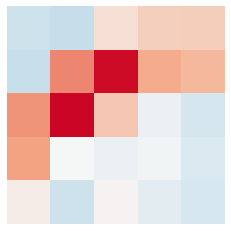

In [ ]:
W_3a_3b_hm = tensor_heatmap(W_3a_3b[379, 147, ...] / W_3a_3b[379, ...].max())
show(W_3a_3b_hm)

By looking at the weights above, we can see how the the following two curve detector neurons are connected to each other.

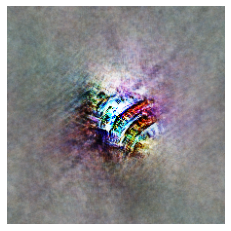

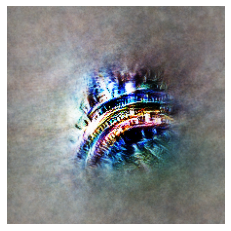

In [ ]:
visualize_activations(model, model.mixed3a, 147)
visualize_activations(model, model.mixed3b, 379)

# NMF Visualizations of expanded weights

Non-negative matrix factorization (NMF) and other dimensionality reduction algorithms can be used to reveal the spaital structure of weights. Below we use onesided NMF dimensionality reduction to collapse the input channels down to 3 dimensions so that we can view them as an RGB image. To make the NMF dimensionality reduction be one-sided, we apply Captum.optim's `posneg` function to make all values in the input positive.

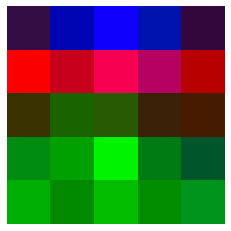

In [ ]:
reducer = optimviz.reducer.ChannelReducer(3, "NMF")

# Make the input positive for one-side NMF
W_3a_3b_posneg = optimviz.reducer.posneg(W_3a_3b, dim=1)

W_nmf = reducer.fit_transform(W_3a_3b_posneg[320, ...])
W_nmf = W_nmf / W_nmf.max()
show(W_nmf)

Using the weights above, we can see how that they match the structure of the target neurons when they are visualized.

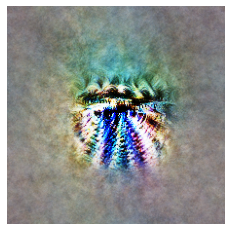

In [ ]:
visualize_activations(model, model.mixed3b, 320)

Seeing how different neurons & their weights compare to each other can also be interesting.

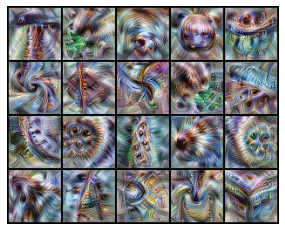

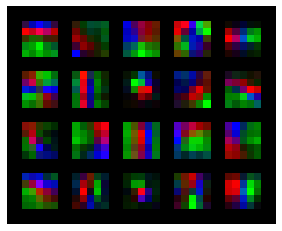

In [ ]:
units = list(range(320, 340))

A = []
for i in range(320, 340):
    x_out = vis_multi(model, model.mixed3b, i)
    A.append(x_out.squeeze(0).detach())

grid_img = torchvision.utils.make_grid(torch.stack(A), nrow=5)
show(grid_img)

A = []
for i in range(320, 340):
    W_nmf = reducer.fit_transform(W_3a_3b_posneg[i, ...])
    W_nmf =  W_nmf / W_nmf.max()
    A.append(W_nmf)

grid_img = torchvision.utils.make_grid(torch.stack(A), nrow=5)
show(grid_img)

One-sided NMF dimensionality reduction can also be used to describe multiple related neurons with a small number of factors. Below we demonstrate this with high-low frequency detectors. The weights have one side corrresponding to high frequency and another to low.

In [ ]:
W_p2_3a = optimviz.circuits.get_expanded_weights(model, model.pool2, model.mixed3a, 5)

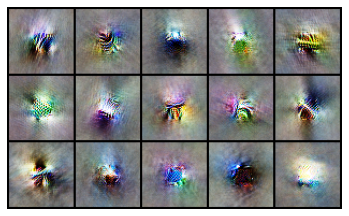

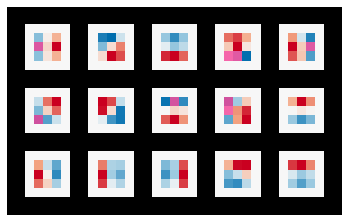

In [ ]:
highlow_units = [110, 180, 153, 106, 112, 186, 132, 136, 117, 113, 108, 70, 86, 88, 160]

# Extract the units that we want to view
W_hl = W_p2_3a[highlow_units, ...]

# Make the input positive for one-side NMF
W_posneg = optimviz.reducer.posneg(W_hl, dim=0)

reducer = optimviz.reducer.ChannelReducer(2, "NMF")
W_nmf = reducer.fit_transform(W_posneg)

W_nmf = W_nmf / W_nmf.max()
W_nmf = W_nmf[:len(highlow_units)] - W_nmf[len(highlow_units):]

A = []
for i in highlow_units:
    x_out = vis_multi(model, model.conv3, i)
    A.append(x_out.squeeze(0).detach())

grid_img = torchvision.utils.make_grid(torch.stack(A), nrow=5)
show(grid_img)

A = []
for i in range(len(highlow_units)):
    W_x = tensor_heatmap(W_nmf[i, 0, ...] / W_nmf[i, 0, ...].max())
    A.append(W_x)

grid_img = torchvision.utils.make_grid(torch.stack(A), nrow=5)
show(grid_img)